# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

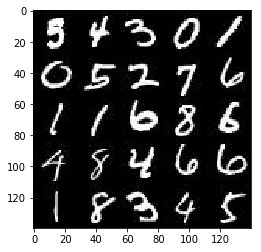

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

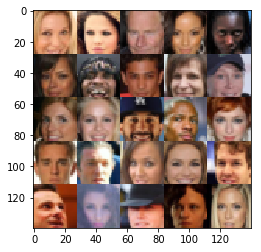

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input_ph = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_ph = tf.placeholder(tf.float32, (None, z_dim))
    lr_ph = tf.placeholder(tf.float32)

    return real_input_ph, z_ph, lr_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/andres/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/andres/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/andres/anaconda3/lib/python3.6/site-packages/zmq/eventloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # I'll use DCGANs for this project, I hope this doesn't comlicate things much
    
    # alpha for the leaky relu activation function
    alpha = 0.05
    rate = 0.5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # first conv layer with 15 filters and a convolution size of 3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # leaky relu
        x1 = leaky_relu(x1,alpha)
        # drop out renormalization
        x1 = tf.contrib.layers.dropout(x1, rate)
        
        # second conv layer with 30 filters and a convulution size of 3
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # We set training = True since we are not planning to further use 
        # the network for inference
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 =leaky_relu(x2, alpha)
        x2 = tf.contrib.layers.dropout(x2, rate)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # We set training = True since we are not planning to further use 
        # the network for inference
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3, alpha)
        x3 = tf.contrib.layers.dropout(x3, rate)
        # flatten convolutions to connect to dense layer
        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        output = tf.sigmoid(logits) 
        
    # why do we need two outputs?
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # alpha for leaky relu
    alpha = 0.05
    rate = 0.5
    # variable scope, when we train we don't reuse scope
    with tf.variable_scope("generator", reuse = not is_train):
        # create convolution stack which will have dims 7 x 7 x 50, 
        x1 = tf.layers.dense(z, 7* 7* 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        # renormalize by batch
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        x1 = tf.contrib.layers.dropout(x1, rate, is_training=is_train)
        
        # second convolution transpose, shape should be 14 x 14 x 25
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        x2 = tf.contrib.layers.dropout(x2,rate, is_training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        x3 = tf.contrib.layers.dropout(x3, rate, is_training=is_train)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding="same", 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4, alpha)
        x4 = tf.contrib.layers.dropout(x4, rate, is_training=is_train)
        
        # final convolution transpose, shape should be 28 x 28 x out_channel_dim, I use a stride of 1 to preserve size
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, 
                                            strides=1, padding="same")
        
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    generator_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    # Why one is True and the other one False
    discriminator_model_real, d_logits_real = discriminator(input_real, reuse=False)
    discriminator_model_fake, d_logits_fake = discriminator(generator_model, reuse=True)
    
    # why discriminator has 2 different losses???
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * (1-smooth)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    # why does the generator_loss depends on d_logits_fake
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake))
    )
    
    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_variables = tf.trainable_variables()
    discriminator_variables = [var for var in all_variables if var.name.startswith("discriminator")]
    generator_variables = [var for var in all_variables if var.name.startswith("generator")]
    
    # what is this with statement doing?
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train\
        .AdamOptimizer(learning_rate=learning_rate, beta1=beta1)\
        .minimize(d_loss, var_list=discriminator_variables)
        
        g_train_opt = tf.train\
        .AdamOptimizer(learning_rate=learning_rate, beta1=beta1)\
        .minimize(g_loss, var_list=generator_variables)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.7051... Generator Loss: 7.3310
Epoch 1/2... Batch 20... Discriminator Loss: 1.5262... Generator Loss: 8.4654
Epoch 1/2... Batch 30... Discriminator Loss: 3.4702... Generator Loss: 2.7326
Epoch 1/2... Batch 40... Discriminator Loss: 3.4932... Generator Loss: 6.5524
Epoch 1/2... Batch 50... Discriminator Loss: 2.5039... Generator Loss: 2.8926
Epoch 1/2... Batch 60... Discriminator Loss: 1.9013... Generator Loss: 3.1638
Epoch 1/2... Batch 70... Discriminator Loss: 1.9992... Generator Loss: 3.7378
Epoch 1/2... Batch 80... Discriminator Loss: 2.6545... Generator Loss: 3.1138
Epoch 1/2... Batch 90... Discriminator Loss: 1.5189... Generator Loss: 3.7551
Epoch 1/2... Batch 100... Discriminator Loss: 1.8017... Generator Loss: 3.4075


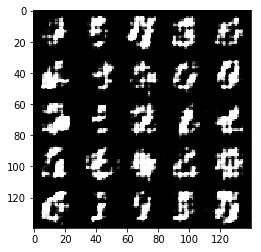

Epoch 1/2... Batch 110... Discriminator Loss: 2.0674... Generator Loss: 2.8411
Epoch 1/2... Batch 120... Discriminator Loss: 2.1075... Generator Loss: 1.8360
Epoch 1/2... Batch 130... Discriminator Loss: 1.7591... Generator Loss: 1.5641
Epoch 1/2... Batch 140... Discriminator Loss: 1.6156... Generator Loss: 2.5629
Epoch 1/2... Batch 150... Discriminator Loss: 1.4316... Generator Loss: 2.2434
Epoch 1/2... Batch 160... Discriminator Loss: 1.5176... Generator Loss: 3.0519
Epoch 1/2... Batch 170... Discriminator Loss: 1.6981... Generator Loss: 2.0146
Epoch 1/2... Batch 180... Discriminator Loss: 1.2854... Generator Loss: 2.1942
Epoch 1/2... Batch 190... Discriminator Loss: 1.3437... Generator Loss: 2.5042
Epoch 1/2... Batch 200... Discriminator Loss: 1.4740... Generator Loss: 1.8829


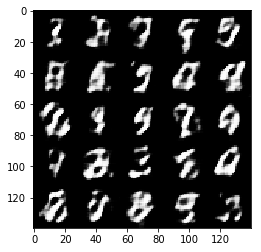

Epoch 1/2... Batch 210... Discriminator Loss: 1.4396... Generator Loss: 2.5265
Epoch 1/2... Batch 220... Discriminator Loss: 1.3846... Generator Loss: 2.7959
Epoch 1/2... Batch 230... Discriminator Loss: 1.4666... Generator Loss: 2.3159
Epoch 1/2... Batch 240... Discriminator Loss: 1.8134... Generator Loss: 1.2784
Epoch 1/2... Batch 250... Discriminator Loss: 1.5615... Generator Loss: 3.1627
Epoch 1/2... Batch 260... Discriminator Loss: 1.3467... Generator Loss: 2.1954
Epoch 1/2... Batch 270... Discriminator Loss: 1.4192... Generator Loss: 2.8859
Epoch 1/2... Batch 280... Discriminator Loss: 1.7184... Generator Loss: 1.4466
Epoch 1/2... Batch 290... Discriminator Loss: 1.3826... Generator Loss: 1.9975
Epoch 1/2... Batch 300... Discriminator Loss: 1.4141... Generator Loss: 1.6659


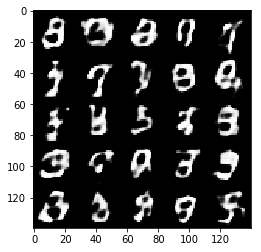

Epoch 1/2... Batch 310... Discriminator Loss: 1.3341... Generator Loss: 2.0606
Epoch 1/2... Batch 320... Discriminator Loss: 1.2091... Generator Loss: 2.2181
Epoch 1/2... Batch 330... Discriminator Loss: 1.4902... Generator Loss: 2.6557
Epoch 1/2... Batch 340... Discriminator Loss: 1.3579... Generator Loss: 2.2373
Epoch 1/2... Batch 350... Discriminator Loss: 1.1016... Generator Loss: 2.7040
Epoch 1/2... Batch 360... Discriminator Loss: 1.2036... Generator Loss: 2.6478
Epoch 1/2... Batch 370... Discriminator Loss: 1.4266... Generator Loss: 3.5517
Epoch 1/2... Batch 380... Discriminator Loss: 1.2654... Generator Loss: 2.0864
Epoch 1/2... Batch 390... Discriminator Loss: 1.0627... Generator Loss: 2.4118
Epoch 1/2... Batch 400... Discriminator Loss: 1.0414... Generator Loss: 2.8447


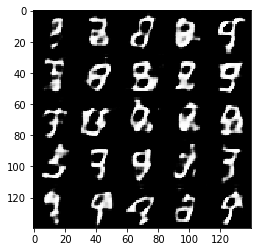

Epoch 1/2... Batch 410... Discriminator Loss: 1.1512... Generator Loss: 1.9500
Epoch 1/2... Batch 420... Discriminator Loss: 1.0950... Generator Loss: 2.1362
Epoch 1/2... Batch 430... Discriminator Loss: 1.0151... Generator Loss: 2.1188
Epoch 1/2... Batch 440... Discriminator Loss: 0.9421... Generator Loss: 2.3652
Epoch 1/2... Batch 450... Discriminator Loss: 1.1498... Generator Loss: 2.6867
Epoch 1/2... Batch 460... Discriminator Loss: 1.0580... Generator Loss: 2.9201
Epoch 2/2... Batch 10... Discriminator Loss: 1.0022... Generator Loss: 2.5455
Epoch 2/2... Batch 20... Discriminator Loss: 1.0657... Generator Loss: 2.3138
Epoch 2/2... Batch 30... Discriminator Loss: 0.9534... Generator Loss: 2.7866
Epoch 2/2... Batch 40... Discriminator Loss: 1.4255... Generator Loss: 0.8981
Epoch 2/2... Batch 50... Discriminator Loss: 1.1308... Generator Loss: 2.9236
Epoch 2/2... Batch 60... Discriminator Loss: 1.0476... Generator Loss: 2.1610
Epoch 2/2... Batch 70... Discriminator Loss: 0.9672... Gen

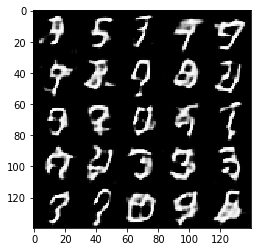

Epoch 2/2... Batch 110... Discriminator Loss: 1.0309... Generator Loss: 3.7324
Epoch 2/2... Batch 120... Discriminator Loss: 0.8978... Generator Loss: 2.2826
Epoch 2/2... Batch 130... Discriminator Loss: 1.1532... Generator Loss: 3.5077
Epoch 2/2... Batch 140... Discriminator Loss: 0.8873... Generator Loss: 3.0063
Epoch 2/2... Batch 150... Discriminator Loss: 0.8644... Generator Loss: 3.0234
Epoch 2/2... Batch 160... Discriminator Loss: 0.9636... Generator Loss: 2.3591
Epoch 2/2... Batch 170... Discriminator Loss: 0.9846... Generator Loss: 1.8743
Epoch 2/2... Batch 180... Discriminator Loss: 0.9520... Generator Loss: 2.9353
Epoch 2/2... Batch 190... Discriminator Loss: 1.0474... Generator Loss: 1.7795
Epoch 2/2... Batch 200... Discriminator Loss: 0.9443... Generator Loss: 2.5184


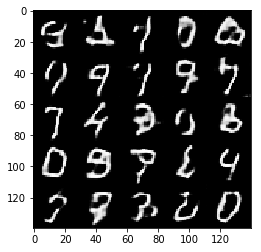

Epoch 2/2... Batch 210... Discriminator Loss: 0.9353... Generator Loss: 2.7971
Epoch 2/2... Batch 220... Discriminator Loss: 0.8800... Generator Loss: 2.4575
Epoch 2/2... Batch 230... Discriminator Loss: 0.8417... Generator Loss: 2.1700
Epoch 2/2... Batch 240... Discriminator Loss: 1.0243... Generator Loss: 1.5916
Epoch 2/2... Batch 250... Discriminator Loss: 0.9773... Generator Loss: 2.0134
Epoch 2/2... Batch 260... Discriminator Loss: 0.8957... Generator Loss: 2.4252
Epoch 2/2... Batch 270... Discriminator Loss: 1.0804... Generator Loss: 3.7830
Epoch 2/2... Batch 280... Discriminator Loss: 0.8883... Generator Loss: 3.1088
Epoch 2/2... Batch 290... Discriminator Loss: 0.8586... Generator Loss: 2.0356
Epoch 2/2... Batch 300... Discriminator Loss: 0.9575... Generator Loss: 3.2543


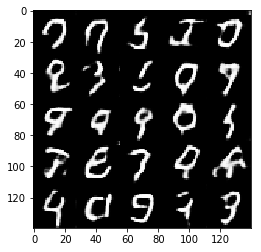

Epoch 2/2... Batch 310... Discriminator Loss: 1.2106... Generator Loss: 1.3945
Epoch 2/2... Batch 320... Discriminator Loss: 0.8073... Generator Loss: 2.5572
Epoch 2/2... Batch 330... Discriminator Loss: 0.9477... Generator Loss: 3.1948
Epoch 2/2... Batch 340... Discriminator Loss: 1.0261... Generator Loss: 2.6669
Epoch 2/2... Batch 350... Discriminator Loss: 0.9457... Generator Loss: 1.9704
Epoch 2/2... Batch 360... Discriminator Loss: 0.9364... Generator Loss: 2.4816
Epoch 2/2... Batch 370... Discriminator Loss: 0.9775... Generator Loss: 3.0271
Epoch 2/2... Batch 380... Discriminator Loss: 0.8454... Generator Loss: 2.1563
Epoch 2/2... Batch 390... Discriminator Loss: 0.8425... Generator Loss: 2.4834
Epoch 2/2... Batch 400... Discriminator Loss: 1.2139... Generator Loss: 4.2858


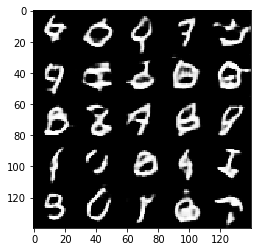

Epoch 2/2... Batch 410... Discriminator Loss: 1.2928... Generator Loss: 1.7016
Epoch 2/2... Batch 420... Discriminator Loss: 0.8242... Generator Loss: 2.8080
Epoch 2/2... Batch 430... Discriminator Loss: 0.9132... Generator Loss: 2.3368
Epoch 2/2... Batch 440... Discriminator Loss: 0.9267... Generator Loss: 2.4624
Epoch 2/2... Batch 450... Discriminator Loss: 0.9000... Generator Loss: 1.7812
Epoch 2/2... Batch 460... Discriminator Loss: 0.8999... Generator Loss: 2.3464


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.5949... Generator Loss: 6.8523
Epoch 1/1... Batch 20... Discriminator Loss: 1.2571... Generator Loss: 10.9582
Epoch 1/1... Batch 30... Discriminator Loss: 1.2991... Generator Loss: 13.6542
Epoch 1/1... Batch 40... Discriminator Loss: 1.1187... Generator Loss: 11.0860
Epoch 1/1... Batch 50... Discriminator Loss: 1.0507... Generator Loss: 10.6819
Epoch 1/1... Batch 60... Discriminator Loss: 1.2369... Generator Loss: 11.2348
Epoch 1/1... Batch 70... Discriminator Loss: 1.3294... Generator Loss: 11.4439
Epoch 1/1... Batch 80... Discriminator Loss: 1.3108... Generator Loss: 6.2445
Epoch 1/1... Batch 90... Discriminator Loss: 5.5794... Generator Loss: 19.4968
Epoch 1/1... Batch 100... Discriminator Loss: 1.1007... Generator Loss: 10.6654


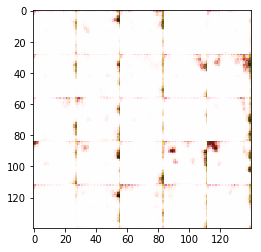

Epoch 1/1... Batch 110... Discriminator Loss: 1.3450... Generator Loss: 10.4169
Epoch 1/1... Batch 120... Discriminator Loss: 0.9369... Generator Loss: 10.4657
Epoch 1/1... Batch 130... Discriminator Loss: 0.9541... Generator Loss: 8.5569
Epoch 1/1... Batch 140... Discriminator Loss: 0.8541... Generator Loss: 10.3514
Epoch 1/1... Batch 150... Discriminator Loss: 1.0009... Generator Loss: 7.2738
Epoch 1/1... Batch 160... Discriminator Loss: 1.1965... Generator Loss: 10.6782
Epoch 1/1... Batch 170... Discriminator Loss: 1.3836... Generator Loss: 5.5508
Epoch 1/1... Batch 180... Discriminator Loss: 0.8454... Generator Loss: 10.3406
Epoch 1/1... Batch 190... Discriminator Loss: 1.7502... Generator Loss: 3.1563
Epoch 1/1... Batch 200... Discriminator Loss: 1.0850... Generator Loss: 7.8714


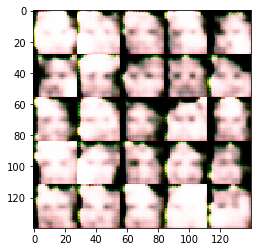

Epoch 1/1... Batch 210... Discriminator Loss: 0.8546... Generator Loss: 8.5461
Epoch 1/1... Batch 220... Discriminator Loss: 0.7925... Generator Loss: 9.3605
Epoch 1/1... Batch 230... Discriminator Loss: 0.7138... Generator Loss: 6.4787
Epoch 1/1... Batch 240... Discriminator Loss: 0.9082... Generator Loss: 8.3002
Epoch 1/1... Batch 250... Discriminator Loss: 2.8833... Generator Loss: 1.4055
Epoch 1/1... Batch 260... Discriminator Loss: 0.7708... Generator Loss: 7.3926
Epoch 1/1... Batch 270... Discriminator Loss: 0.6388... Generator Loss: 5.8181
Epoch 1/1... Batch 280... Discriminator Loss: 0.7332... Generator Loss: 5.6406
Epoch 1/1... Batch 290... Discriminator Loss: 0.8284... Generator Loss: 5.9973
Epoch 1/1... Batch 300... Discriminator Loss: 0.8799... Generator Loss: 4.6374


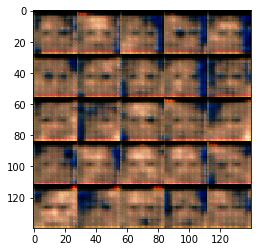

Epoch 1/1... Batch 310... Discriminator Loss: 0.8458... Generator Loss: 6.0475
Epoch 1/1... Batch 320... Discriminator Loss: 0.7016... Generator Loss: 4.0507
Epoch 1/1... Batch 330... Discriminator Loss: 0.7373... Generator Loss: 5.6503
Epoch 1/1... Batch 340... Discriminator Loss: 0.8850... Generator Loss: 3.9780
Epoch 1/1... Batch 350... Discriminator Loss: 0.9026... Generator Loss: 4.3773
Epoch 1/1... Batch 360... Discriminator Loss: 0.6463... Generator Loss: 4.7989
Epoch 1/1... Batch 370... Discriminator Loss: 0.6726... Generator Loss: 4.1644
Epoch 1/1... Batch 380... Discriminator Loss: 1.3776... Generator Loss: 6.2980
Epoch 1/1... Batch 390... Discriminator Loss: 0.9171... Generator Loss: 4.9161
Epoch 1/1... Batch 400... Discriminator Loss: 0.6026... Generator Loss: 3.7379


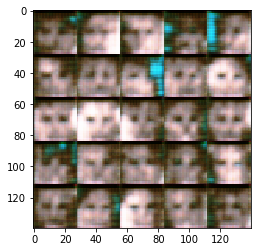

Epoch 1/1... Batch 410... Discriminator Loss: 0.8184... Generator Loss: 3.1211
Epoch 1/1... Batch 420... Discriminator Loss: 0.8786... Generator Loss: 3.5123
Epoch 1/1... Batch 430... Discriminator Loss: 0.5784... Generator Loss: 3.9292
Epoch 1/1... Batch 440... Discriminator Loss: 0.8147... Generator Loss: 6.7656
Epoch 1/1... Batch 450... Discriminator Loss: 0.8256... Generator Loss: 3.5609
Epoch 1/1... Batch 460... Discriminator Loss: 0.8213... Generator Loss: 3.6458
Epoch 1/1... Batch 470... Discriminator Loss: 1.1014... Generator Loss: 1.7570
Epoch 1/1... Batch 480... Discriminator Loss: 0.7006... Generator Loss: 3.0935
Epoch 1/1... Batch 490... Discriminator Loss: 0.9533... Generator Loss: 2.1373
Epoch 1/1... Batch 500... Discriminator Loss: 1.1084... Generator Loss: 2.5352


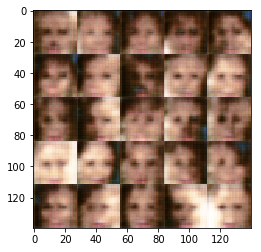

Epoch 1/1... Batch 510... Discriminator Loss: 0.9348... Generator Loss: 1.9888
Epoch 1/1... Batch 520... Discriminator Loss: 0.7401... Generator Loss: 2.2464
Epoch 1/1... Batch 530... Discriminator Loss: 0.7861... Generator Loss: 1.9565
Epoch 1/1... Batch 540... Discriminator Loss: 1.2101... Generator Loss: 1.7869
Epoch 1/1... Batch 550... Discriminator Loss: 0.8382... Generator Loss: 2.3200
Epoch 1/1... Batch 560... Discriminator Loss: 0.6465... Generator Loss: 2.7807
Epoch 1/1... Batch 570... Discriminator Loss: 1.0869... Generator Loss: 1.3493
Epoch 1/1... Batch 580... Discriminator Loss: 0.9175... Generator Loss: 1.8775
Epoch 1/1... Batch 590... Discriminator Loss: 1.0351... Generator Loss: 1.7650
Epoch 1/1... Batch 600... Discriminator Loss: 0.9620... Generator Loss: 2.5255


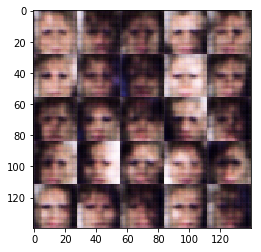

Epoch 1/1... Batch 610... Discriminator Loss: 0.6487... Generator Loss: 2.5106
Epoch 1/1... Batch 620... Discriminator Loss: 0.7448... Generator Loss: 2.6692
Epoch 1/1... Batch 630... Discriminator Loss: 0.7799... Generator Loss: 2.7360
Epoch 1/1... Batch 640... Discriminator Loss: 0.7242... Generator Loss: 2.5161
Epoch 1/1... Batch 650... Discriminator Loss: 0.8952... Generator Loss: 2.4072
Epoch 1/1... Batch 660... Discriminator Loss: 0.8351... Generator Loss: 1.7101
Epoch 1/1... Batch 670... Discriminator Loss: 0.8676... Generator Loss: 2.3248
Epoch 1/1... Batch 680... Discriminator Loss: 0.8265... Generator Loss: 2.7208
Epoch 1/1... Batch 690... Discriminator Loss: 0.7909... Generator Loss: 2.2350
Epoch 1/1... Batch 700... Discriminator Loss: 0.8019... Generator Loss: 2.3675


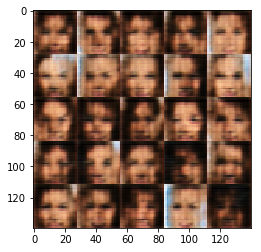

Epoch 1/1... Batch 710... Discriminator Loss: 0.7132... Generator Loss: 3.0384
Epoch 1/1... Batch 720... Discriminator Loss: 0.7707... Generator Loss: 2.4145
Epoch 1/1... Batch 730... Discriminator Loss: 0.6878... Generator Loss: 1.9540
Epoch 1/1... Batch 740... Discriminator Loss: 0.8155... Generator Loss: 1.8438
Epoch 1/1... Batch 750... Discriminator Loss: 0.8081... Generator Loss: 2.1445
Epoch 1/1... Batch 760... Discriminator Loss: 0.8136... Generator Loss: 2.1246
Epoch 1/1... Batch 770... Discriminator Loss: 0.7627... Generator Loss: 3.1170
Epoch 1/1... Batch 780... Discriminator Loss: 0.7720... Generator Loss: 2.4878
Epoch 1/1... Batch 790... Discriminator Loss: 0.8428... Generator Loss: 2.5481
Epoch 1/1... Batch 800... Discriminator Loss: 1.0046... Generator Loss: 2.4102


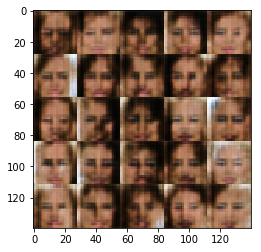

Epoch 1/1... Batch 810... Discriminator Loss: 0.7856... Generator Loss: 2.4052
Epoch 1/1... Batch 820... Discriminator Loss: 0.7028... Generator Loss: 2.3632
Epoch 1/1... Batch 830... Discriminator Loss: 0.8455... Generator Loss: 1.7334
Epoch 1/1... Batch 840... Discriminator Loss: 0.9262... Generator Loss: 1.5209
Epoch 1/1... Batch 850... Discriminator Loss: 0.6266... Generator Loss: 2.8078
Epoch 1/1... Batch 860... Discriminator Loss: 0.7856... Generator Loss: 2.5686
Epoch 1/1... Batch 870... Discriminator Loss: 0.6569... Generator Loss: 2.1495
Epoch 1/1... Batch 880... Discriminator Loss: 0.5954... Generator Loss: 3.1720
Epoch 1/1... Batch 890... Discriminator Loss: 0.6995... Generator Loss: 2.6594
Epoch 1/1... Batch 900... Discriminator Loss: 0.7968... Generator Loss: 2.6472


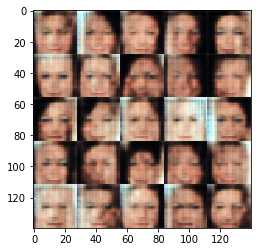

Epoch 1/1... Batch 910... Discriminator Loss: 0.7931... Generator Loss: 3.0511
Epoch 1/1... Batch 920... Discriminator Loss: 0.6371... Generator Loss: 2.3966
Epoch 1/1... Batch 930... Discriminator Loss: 1.9024... Generator Loss: 4.7850
Epoch 1/1... Batch 940... Discriminator Loss: 0.7828... Generator Loss: 1.6506
Epoch 1/1... Batch 950... Discriminator Loss: 0.7022... Generator Loss: 2.7131
Epoch 1/1... Batch 960... Discriminator Loss: 0.7149... Generator Loss: 3.2769
Epoch 1/1... Batch 970... Discriminator Loss: 0.7902... Generator Loss: 2.7720
Epoch 1/1... Batch 980... Discriminator Loss: 0.8911... Generator Loss: 2.4785
Epoch 1/1... Batch 990... Discriminator Loss: 1.1563... Generator Loss: 1.5105
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7503... Generator Loss: 2.1074


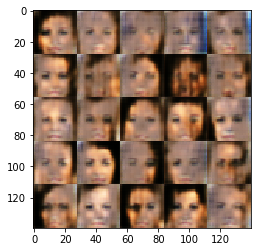

Epoch 1/1... Batch 1010... Discriminator Loss: 0.7520... Generator Loss: 1.7986
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9444... Generator Loss: 2.8134
Epoch 1/1... Batch 1030... Discriminator Loss: 0.9216... Generator Loss: 2.2534
Epoch 1/1... Batch 1040... Discriminator Loss: 0.8055... Generator Loss: 1.8694
Epoch 1/1... Batch 1050... Discriminator Loss: 0.7493... Generator Loss: 2.4560
Epoch 1/1... Batch 1060... Discriminator Loss: 0.6214... Generator Loss: 3.0495
Epoch 1/1... Batch 1070... Discriminator Loss: 0.8552... Generator Loss: 2.6409
Epoch 1/1... Batch 1080... Discriminator Loss: 0.6806... Generator Loss: 2.1223
Epoch 1/1... Batch 1090... Discriminator Loss: 0.8130... Generator Loss: 1.4320
Epoch 1/1... Batch 1100... Discriminator Loss: 0.7493... Generator Loss: 1.6533


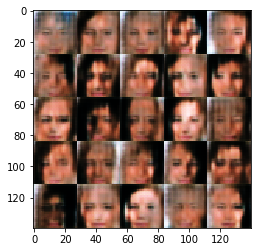

Epoch 1/1... Batch 1110... Discriminator Loss: 0.7808... Generator Loss: 2.4596
Epoch 1/1... Batch 1120... Discriminator Loss: 0.9074... Generator Loss: 2.0264
Epoch 1/1... Batch 1130... Discriminator Loss: 0.9767... Generator Loss: 3.2678
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1527... Generator Loss: 3.6967
Epoch 1/1... Batch 1150... Discriminator Loss: 0.7236... Generator Loss: 2.1948
Epoch 1/1... Batch 1160... Discriminator Loss: 0.8911... Generator Loss: 1.6775
Epoch 1/1... Batch 1170... Discriminator Loss: 0.7668... Generator Loss: 2.0688
Epoch 1/1... Batch 1180... Discriminator Loss: 0.8218... Generator Loss: 2.0308
Epoch 1/1... Batch 1190... Discriminator Loss: 0.7423... Generator Loss: 2.4670
Epoch 1/1... Batch 1200... Discriminator Loss: 0.7179... Generator Loss: 3.1464


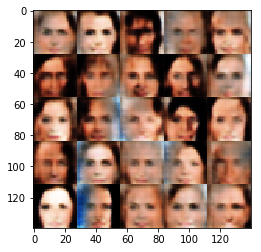

Epoch 1/1... Batch 1210... Discriminator Loss: 0.7440... Generator Loss: 1.6011
Epoch 1/1... Batch 1220... Discriminator Loss: 0.6384... Generator Loss: 1.8565
Epoch 1/1... Batch 1230... Discriminator Loss: 0.6958... Generator Loss: 1.5812
Epoch 1/1... Batch 1240... Discriminator Loss: 0.8050... Generator Loss: 1.9740
Epoch 1/1... Batch 1250... Discriminator Loss: 0.9372... Generator Loss: 2.2110
Epoch 1/1... Batch 1260... Discriminator Loss: 0.9886... Generator Loss: 1.5960
Epoch 1/1... Batch 1270... Discriminator Loss: 0.7713... Generator Loss: 2.3402
Epoch 1/1... Batch 1280... Discriminator Loss: 0.7704... Generator Loss: 2.4720
Epoch 1/1... Batch 1290... Discriminator Loss: 0.9352... Generator Loss: 1.6237
Epoch 1/1... Batch 1300... Discriminator Loss: 0.7197... Generator Loss: 2.2554


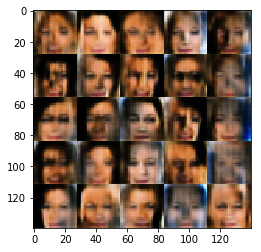

Epoch 1/1... Batch 1310... Discriminator Loss: 1.0560... Generator Loss: 1.8717
Epoch 1/1... Batch 1320... Discriminator Loss: 0.7861... Generator Loss: 2.0561
Epoch 1/1... Batch 1330... Discriminator Loss: 0.6980... Generator Loss: 2.4567
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0505... Generator Loss: 2.5845
Epoch 1/1... Batch 1350... Discriminator Loss: 0.8231... Generator Loss: 1.7004
Epoch 1/1... Batch 1360... Discriminator Loss: 0.7416... Generator Loss: 2.1666
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1437... Generator Loss: 1.5055
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9891... Generator Loss: 1.7724
Epoch 1/1... Batch 1390... Discriminator Loss: 0.9328... Generator Loss: 1.9587
Epoch 1/1... Batch 1400... Discriminator Loss: 0.7771... Generator Loss: 1.6293


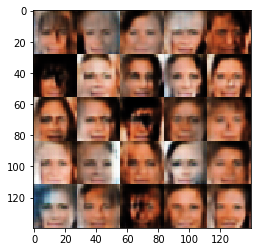

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9727... Generator Loss: 1.7784
Epoch 1/1... Batch 1420... Discriminator Loss: 0.8256... Generator Loss: 1.9439
Epoch 1/1... Batch 1430... Discriminator Loss: 0.8417... Generator Loss: 1.9969
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3349... Generator Loss: 2.5026
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2231... Generator Loss: 1.0896
Epoch 1/1... Batch 1460... Discriminator Loss: 0.8450... Generator Loss: 2.3715
Epoch 1/1... Batch 1470... Discriminator Loss: 0.8569... Generator Loss: 1.6522
Epoch 1/1... Batch 1480... Discriminator Loss: 0.9045... Generator Loss: 1.7864
Epoch 1/1... Batch 1490... Discriminator Loss: 0.9065... Generator Loss: 3.4515
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9631... Generator Loss: 2.4005


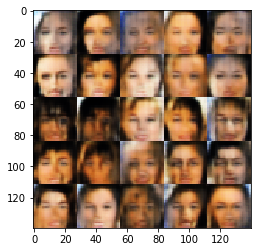

Epoch 1/1... Batch 1510... Discriminator Loss: 0.8608... Generator Loss: 1.4709
Epoch 1/1... Batch 1520... Discriminator Loss: 0.8062... Generator Loss: 1.7591
Epoch 1/1... Batch 1530... Discriminator Loss: 1.2235... Generator Loss: 2.7042
Epoch 1/1... Batch 1540... Discriminator Loss: 1.6179... Generator Loss: 3.2489
Epoch 1/1... Batch 1550... Discriminator Loss: 0.8790... Generator Loss: 2.4336
Epoch 1/1... Batch 1560... Discriminator Loss: 0.9461... Generator Loss: 1.3334
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9839... Generator Loss: 2.0315
Epoch 1/1... Batch 1580... Discriminator Loss: 0.9218... Generator Loss: 1.7849
Epoch 1/1... Batch 1590... Discriminator Loss: 0.8132... Generator Loss: 1.3451
Epoch 1/1... Batch 1600... Discriminator Loss: 0.8269... Generator Loss: 2.0725


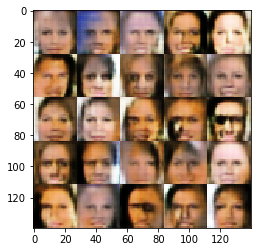

Epoch 1/1... Batch 1610... Discriminator Loss: 1.0821... Generator Loss: 1.6094
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8686... Generator Loss: 2.2939
Epoch 1/1... Batch 1630... Discriminator Loss: 0.7586... Generator Loss: 1.4613
Epoch 1/1... Batch 1640... Discriminator Loss: 0.9257... Generator Loss: 1.7461
Epoch 1/1... Batch 1650... Discriminator Loss: 0.7765... Generator Loss: 2.0586
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9104... Generator Loss: 2.1222
Epoch 1/1... Batch 1670... Discriminator Loss: 0.9503... Generator Loss: 1.1880
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0057... Generator Loss: 1.3908
Epoch 1/1... Batch 1690... Discriminator Loss: 1.0076... Generator Loss: 1.3077
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2377... Generator Loss: 1.6182


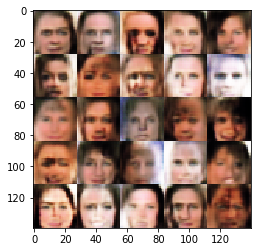

Epoch 1/1... Batch 1710... Discriminator Loss: 0.7765... Generator Loss: 1.6748
Epoch 1/1... Batch 1720... Discriminator Loss: 0.8887... Generator Loss: 1.9265
Epoch 1/1... Batch 1730... Discriminator Loss: 0.8637... Generator Loss: 1.6861
Epoch 1/1... Batch 1740... Discriminator Loss: 1.0875... Generator Loss: 2.4802
Epoch 1/1... Batch 1750... Discriminator Loss: 0.7907... Generator Loss: 1.6312
Epoch 1/1... Batch 1760... Discriminator Loss: 0.8853... Generator Loss: 2.0821
Epoch 1/1... Batch 1770... Discriminator Loss: 0.8579... Generator Loss: 1.8505
Epoch 1/1... Batch 1780... Discriminator Loss: 0.9037... Generator Loss: 2.0553
Epoch 1/1... Batch 1790... Discriminator Loss: 0.9850... Generator Loss: 1.7090
Epoch 1/1... Batch 1800... Discriminator Loss: 1.5460... Generator Loss: 0.9381


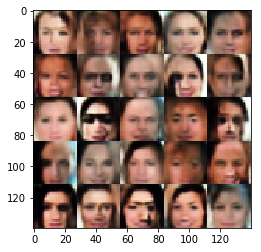

Epoch 1/1... Batch 1810... Discriminator Loss: 1.0914... Generator Loss: 1.2387
Epoch 1/1... Batch 1820... Discriminator Loss: 0.8813... Generator Loss: 1.3123
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0329... Generator Loss: 1.1729
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1275... Generator Loss: 1.7036
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4164... Generator Loss: 1.2372
Epoch 1/1... Batch 1860... Discriminator Loss: 1.0077... Generator Loss: 2.1702
Epoch 1/1... Batch 1870... Discriminator Loss: 0.7450... Generator Loss: 1.5364
Epoch 1/1... Batch 1880... Discriminator Loss: 0.9980... Generator Loss: 1.5594
Epoch 1/1... Batch 1890... Discriminator Loss: 1.2404... Generator Loss: 1.4834
Epoch 1/1... Batch 1900... Discriminator Loss: 1.0284... Generator Loss: 1.7363


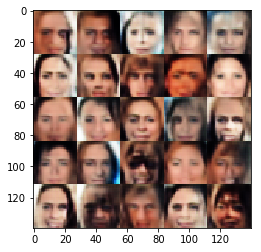

Epoch 1/1... Batch 1910... Discriminator Loss: 0.9201... Generator Loss: 1.1580
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0746... Generator Loss: 2.4460
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9329... Generator Loss: 1.6448
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1317... Generator Loss: 2.0499
Epoch 1/1... Batch 1950... Discriminator Loss: 0.7538... Generator Loss: 1.9536
Epoch 1/1... Batch 1960... Discriminator Loss: 1.0847... Generator Loss: 1.1253
Epoch 1/1... Batch 1970... Discriminator Loss: 0.7834... Generator Loss: 2.5632
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1331... Generator Loss: 2.4984
Epoch 1/1... Batch 1990... Discriminator Loss: 1.0056... Generator Loss: 1.6024
Epoch 1/1... Batch 2000... Discriminator Loss: 0.9362... Generator Loss: 1.3844


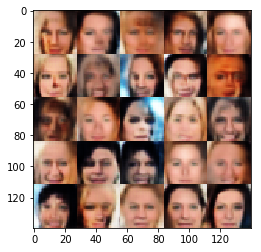

Epoch 1/1... Batch 2010... Discriminator Loss: 0.7973... Generator Loss: 1.8523
Epoch 1/1... Batch 2020... Discriminator Loss: 0.8548... Generator Loss: 1.3951
Epoch 1/1... Batch 2030... Discriminator Loss: 0.7485... Generator Loss: 1.3114
Epoch 1/1... Batch 2040... Discriminator Loss: 1.0454... Generator Loss: 1.1363
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9243... Generator Loss: 1.2219
Epoch 1/1... Batch 2060... Discriminator Loss: 0.9085... Generator Loss: 2.6257
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1959... Generator Loss: 1.0704
Epoch 1/1... Batch 2080... Discriminator Loss: 0.8253... Generator Loss: 1.7470
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0170... Generator Loss: 1.5242
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0469... Generator Loss: 1.0355


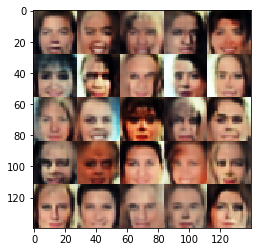

Epoch 1/1... Batch 2110... Discriminator Loss: 1.4016... Generator Loss: 3.0311
Epoch 1/1... Batch 2120... Discriminator Loss: 0.9382... Generator Loss: 1.4969
Epoch 1/1... Batch 2130... Discriminator Loss: 1.1398... Generator Loss: 2.6430
Epoch 1/1... Batch 2140... Discriminator Loss: 1.0941... Generator Loss: 2.0197
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1315... Generator Loss: 1.3347
Epoch 1/1... Batch 2160... Discriminator Loss: 0.8162... Generator Loss: 1.2009
Epoch 1/1... Batch 2170... Discriminator Loss: 0.8422... Generator Loss: 1.9582
Epoch 1/1... Batch 2180... Discriminator Loss: 1.0408... Generator Loss: 1.8227
Epoch 1/1... Batch 2190... Discriminator Loss: 0.9094... Generator Loss: 1.3952
Epoch 1/1... Batch 2200... Discriminator Loss: 1.0241... Generator Loss: 1.5775


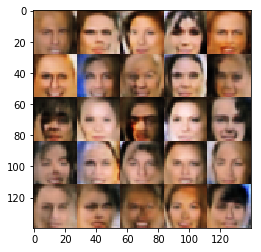

Epoch 1/1... Batch 2210... Discriminator Loss: 0.8528... Generator Loss: 1.6336
Epoch 1/1... Batch 2220... Discriminator Loss: 0.8570... Generator Loss: 1.8402
Epoch 1/1... Batch 2230... Discriminator Loss: 0.9043... Generator Loss: 1.2690
Epoch 1/1... Batch 2240... Discriminator Loss: 0.9773... Generator Loss: 1.7584
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1537... Generator Loss: 0.9087
Epoch 1/1... Batch 2260... Discriminator Loss: 0.9157... Generator Loss: 2.1442
Epoch 1/1... Batch 2270... Discriminator Loss: 0.9163... Generator Loss: 1.6867
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0024... Generator Loss: 1.4636
Epoch 1/1... Batch 2290... Discriminator Loss: 0.8528... Generator Loss: 1.2746
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0358... Generator Loss: 1.4182


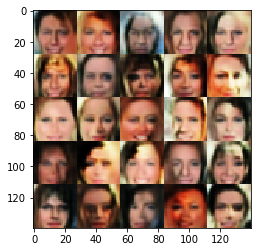

Epoch 1/1... Batch 2310... Discriminator Loss: 0.7731... Generator Loss: 1.8417
Epoch 1/1... Batch 2320... Discriminator Loss: 1.1223... Generator Loss: 2.4973
Epoch 1/1... Batch 2330... Discriminator Loss: 0.8911... Generator Loss: 1.6744
Epoch 1/1... Batch 2340... Discriminator Loss: 1.0029... Generator Loss: 1.5731
Epoch 1/1... Batch 2350... Discriminator Loss: 1.0386... Generator Loss: 1.5305
Epoch 1/1... Batch 2360... Discriminator Loss: 0.9423... Generator Loss: 1.5002
Epoch 1/1... Batch 2370... Discriminator Loss: 0.9323... Generator Loss: 1.5788
Epoch 1/1... Batch 2380... Discriminator Loss: 0.9258... Generator Loss: 1.6227
Epoch 1/1... Batch 2390... Discriminator Loss: 0.9265... Generator Loss: 2.4757
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0800... Generator Loss: 1.8136


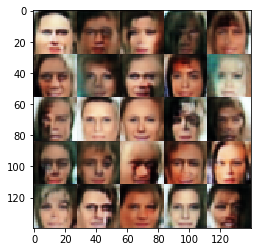

Epoch 1/1... Batch 2410... Discriminator Loss: 1.1274... Generator Loss: 1.5924
Epoch 1/1... Batch 2420... Discriminator Loss: 1.0609... Generator Loss: 1.5574
Epoch 1/1... Batch 2430... Discriminator Loss: 1.0839... Generator Loss: 1.2212
Epoch 1/1... Batch 2440... Discriminator Loss: 0.9329... Generator Loss: 1.6964
Epoch 1/1... Batch 2450... Discriminator Loss: 1.5057... Generator Loss: 4.0504
Epoch 1/1... Batch 2460... Discriminator Loss: 1.0163... Generator Loss: 1.2287
Epoch 1/1... Batch 2470... Discriminator Loss: 1.2068... Generator Loss: 1.3324
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1095... Generator Loss: 1.2720
Epoch 1/1... Batch 2490... Discriminator Loss: 1.0379... Generator Loss: 1.8733
Epoch 1/1... Batch 2500... Discriminator Loss: 0.9287... Generator Loss: 1.5351


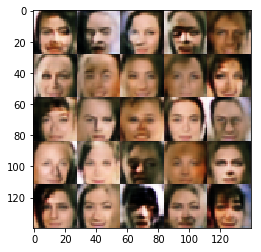

Epoch 1/1... Batch 2510... Discriminator Loss: 1.0878... Generator Loss: 1.4719
Epoch 1/1... Batch 2520... Discriminator Loss: 1.0734... Generator Loss: 1.1910
Epoch 1/1... Batch 2530... Discriminator Loss: 1.1228... Generator Loss: 0.9358
Epoch 1/1... Batch 2540... Discriminator Loss: 1.0522... Generator Loss: 2.0488
Epoch 1/1... Batch 2550... Discriminator Loss: 1.1168... Generator Loss: 1.8780
Epoch 1/1... Batch 2560... Discriminator Loss: 1.1574... Generator Loss: 2.4962
Epoch 1/1... Batch 2570... Discriminator Loss: 0.9325... Generator Loss: 1.4273
Epoch 1/1... Batch 2580... Discriminator Loss: 0.9304... Generator Loss: 1.3304
Epoch 1/1... Batch 2590... Discriminator Loss: 1.0503... Generator Loss: 1.3492
Epoch 1/1... Batch 2600... Discriminator Loss: 0.8496... Generator Loss: 1.7787


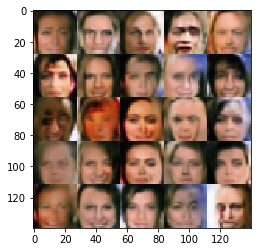

Epoch 1/1... Batch 2610... Discriminator Loss: 1.1754... Generator Loss: 2.5330
Epoch 1/1... Batch 2620... Discriminator Loss: 1.1038... Generator Loss: 1.6339
Epoch 1/1... Batch 2630... Discriminator Loss: 1.0434... Generator Loss: 1.2539
Epoch 1/1... Batch 2640... Discriminator Loss: 1.2989... Generator Loss: 2.0530
Epoch 1/1... Batch 2650... Discriminator Loss: 1.0441... Generator Loss: 1.0083
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8943... Generator Loss: 1.7899
Epoch 1/1... Batch 2670... Discriminator Loss: 0.8859... Generator Loss: 1.9965
Epoch 1/1... Batch 2680... Discriminator Loss: 1.0488... Generator Loss: 1.5037
Epoch 1/1... Batch 2690... Discriminator Loss: 0.8742... Generator Loss: 1.6617
Epoch 1/1... Batch 2700... Discriminator Loss: 0.8946... Generator Loss: 1.6140


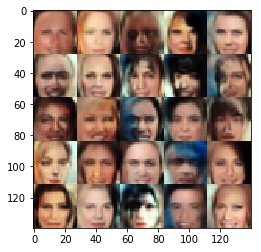

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0817... Generator Loss: 1.5114
Epoch 1/1... Batch 2720... Discriminator Loss: 0.9725... Generator Loss: 1.5410
Epoch 1/1... Batch 2730... Discriminator Loss: 1.4677... Generator Loss: 2.8271
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2742... Generator Loss: 2.9812
Epoch 1/1... Batch 2750... Discriminator Loss: 1.0369... Generator Loss: 1.0890
Epoch 1/1... Batch 2760... Discriminator Loss: 1.0793... Generator Loss: 1.2553
Epoch 1/1... Batch 2770... Discriminator Loss: 0.9721... Generator Loss: 1.2392
Epoch 1/1... Batch 2780... Discriminator Loss: 0.8263... Generator Loss: 1.2897
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1058... Generator Loss: 1.6685
Epoch 1/1... Batch 2800... Discriminator Loss: 0.9038... Generator Loss: 1.6710


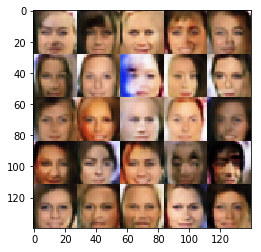

Epoch 1/1... Batch 2810... Discriminator Loss: 0.9746... Generator Loss: 1.1720
Epoch 1/1... Batch 2820... Discriminator Loss: 1.0893... Generator Loss: 1.3243
Epoch 1/1... Batch 2830... Discriminator Loss: 1.1848... Generator Loss: 1.2106
Epoch 1/1... Batch 2840... Discriminator Loss: 0.8139... Generator Loss: 1.4468
Epoch 1/1... Batch 2850... Discriminator Loss: 1.0798... Generator Loss: 1.5974
Epoch 1/1... Batch 2860... Discriminator Loss: 1.1786... Generator Loss: 1.3370
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0503... Generator Loss: 1.2673
Epoch 1/1... Batch 2880... Discriminator Loss: 0.8733... Generator Loss: 1.2238
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1358... Generator Loss: 1.5461
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1262... Generator Loss: 2.5984


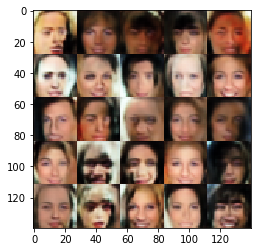

Epoch 1/1... Batch 2910... Discriminator Loss: 1.1065... Generator Loss: 1.2849
Epoch 1/1... Batch 2920... Discriminator Loss: 1.0421... Generator Loss: 2.2481
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1299... Generator Loss: 1.1071
Epoch 1/1... Batch 2940... Discriminator Loss: 1.0187... Generator Loss: 2.1825
Epoch 1/1... Batch 2950... Discriminator Loss: 0.9960... Generator Loss: 1.4523
Epoch 1/1... Batch 2960... Discriminator Loss: 1.1298... Generator Loss: 1.0665
Epoch 1/1... Batch 2970... Discriminator Loss: 1.0798... Generator Loss: 1.7954
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0054... Generator Loss: 1.4890
Epoch 1/1... Batch 2990... Discriminator Loss: 0.8660... Generator Loss: 1.3881
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0631... Generator Loss: 2.3714


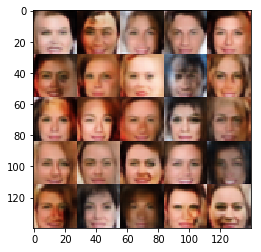

Epoch 1/1... Batch 3010... Discriminator Loss: 0.9324... Generator Loss: 1.4614
Epoch 1/1... Batch 3020... Discriminator Loss: 1.0634... Generator Loss: 1.8068
Epoch 1/1... Batch 3030... Discriminator Loss: 1.0571... Generator Loss: 1.8604
Epoch 1/1... Batch 3040... Discriminator Loss: 0.9551... Generator Loss: 1.7159
Epoch 1/1... Batch 3050... Discriminator Loss: 0.9832... Generator Loss: 1.6522
Epoch 1/1... Batch 3060... Discriminator Loss: 0.9942... Generator Loss: 1.8896
Epoch 1/1... Batch 3070... Discriminator Loss: 0.8436... Generator Loss: 1.3843
Epoch 1/1... Batch 3080... Discriminator Loss: 1.0371... Generator Loss: 1.3078
Epoch 1/1... Batch 3090... Discriminator Loss: 0.8271... Generator Loss: 1.6548
Epoch 1/1... Batch 3100... Discriminator Loss: 0.9666... Generator Loss: 1.4860


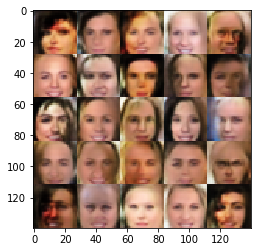

Epoch 1/1... Batch 3110... Discriminator Loss: 0.9775... Generator Loss: 1.2858
Epoch 1/1... Batch 3120... Discriminator Loss: 1.0074... Generator Loss: 0.9522
Epoch 1/1... Batch 3130... Discriminator Loss: 1.0119... Generator Loss: 1.4744
Epoch 1/1... Batch 3140... Discriminator Loss: 1.1254... Generator Loss: 1.3876
Epoch 1/1... Batch 3150... Discriminator Loss: 1.1088... Generator Loss: 1.4747
Epoch 1/1... Batch 3160... Discriminator Loss: 1.0505... Generator Loss: 1.2614


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.